# Language Model NLP - Tamil 
## ( தமிழ் மொழி - இயற்கை மொழி செயலாக்கம் )

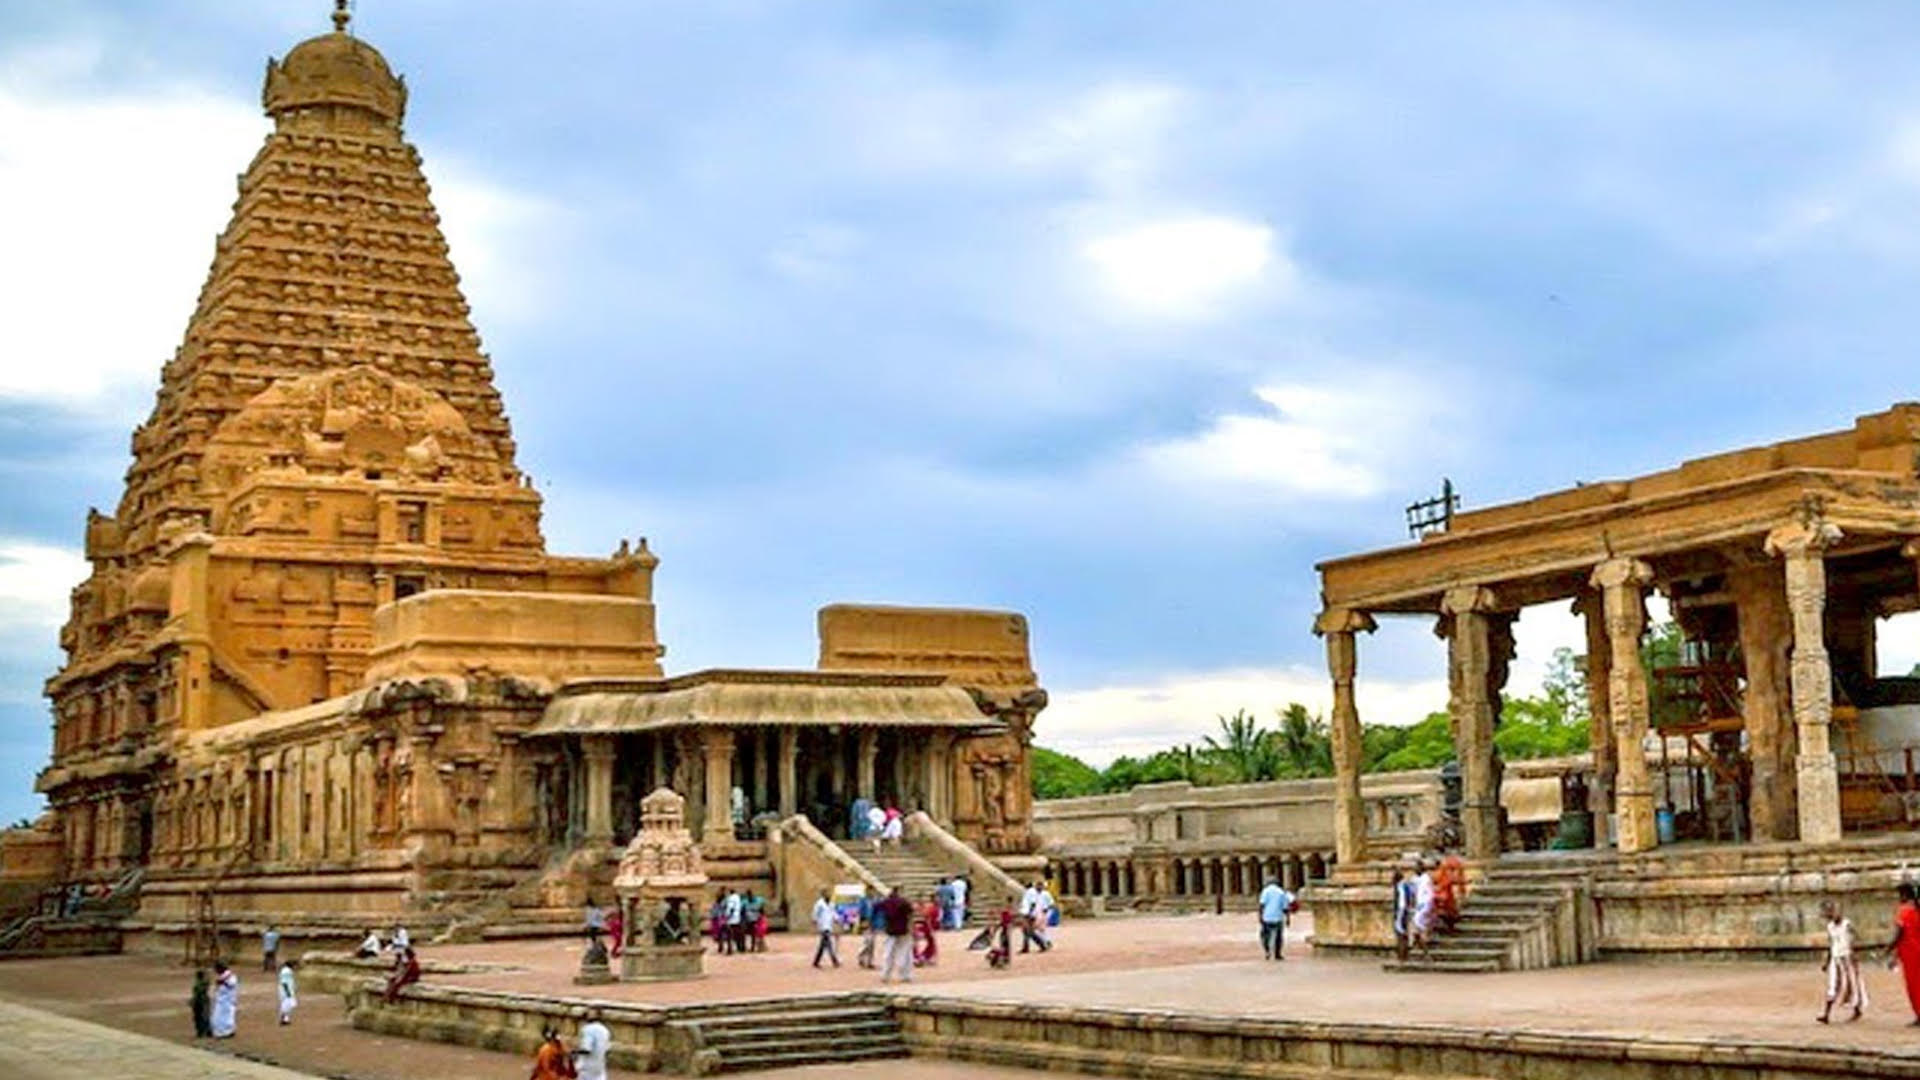

In [2]:
from IPython.display import Image
Image(filename='Tamil-Thanjavur.jpg', width=1200, height=100)

## Importing necessary libraries

In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai import *
from fastai.text import *
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Initializing necessary params for language model

In [ ]:
bs=128
lang = 'ta'

### Dataset you can download from below link

#### https://www.kaggle.com/praveengovi/tamil-language-corpus-for-nlp

In [ ]:
name = f'{lang}wiki'
path = data_path+name+'/'
!mkdir -p '/kaggle/working/dataset/{lang}wiki'
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']
input_dataset_path="../input/tamil-language-corpus-for-nlp/tamil-language-Corpus/tamil-language-Corpus/train/"

!mkdir -p '/kaggle/working/model/{lang}wiki/'
model_path='/kaggle/working/model/{lang}wiki/'

In [ ]:
## !mkdir -p /kaggle/working/dataset/
## data_path='/kaggle/working/dataset/'

# Data Preperation

In [ ]:
data = (TextList.from_folder(input_dataset_path)
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=1))

In [ ]:
data.save(f'{path}{lang}_databunch')
len(data.vocab.itos),len(data.train_ds)

In [ ]:
data = load_data(path, f'{path}{lang}_databunch', bs=bs)

## Define the Language model

In [ ]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()



Language model used
##### AWD_LSTM -> https://docs.fast.ai/text.models.html
##### More idea on Neural Architectures - LSTM & RNN is required to understand more about neural model which we gonna use in the language model

In [ ]:
## Initializing the Learning rate for the Deep Neural network
lr = 1e-2
lr *= bs/48          # Scale learning rate by batch size
Cycles_to_train=2    # No. of cycles neural language model to train

### Train the language model on Tamil Wikipedia - Articles
##### Model will start of learn from intial random weights

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(Cycles_to_train, lr, moms=(0.8,0.7))

In [ ]:
model_path='/kaggle/working/dataset/tawiki/models/'

In [ ]:
learn.to_fp32().save(model_path+'/'+lm_fns[0], with_opt=False)
learn.data.vocab.save(model_path+'/'+lm_fns[1] + '.pkl')

### Ta Da! we have Done with creating the langugage model

### Come on Let we  think 🤔 , How we can best of the language model 

### Let start building Tamil news classifier model with above language model with transfer learning approach

#####  Tamil News dataset is avaialble in kaggle - Under News corpus in below link 

https://www.kaggle.com/praveengovi/tamil-language-corpus-for-nlp

In [ ]:
df = pd.read_csv("../input/tamil-language-corpus-for-nlp/Tamil_News_Corpus/Tamil_news_Dataset/Tamilmurasu_dataset_06_Jan_2011_06_Jan_2020.csv")

In [ ]:
df.head()

In [ ]:
data_lm = (TextList.from_df(df, path, cols='news_article')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

In [ ]:
lm_fns

### Lets initialize the model

In [ ]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [ ]:
## Define the learning rates

lr = 1e-3
lr *= bs/48

### Train the model with News dataset 

In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, lr, moms=(0.8,0.7))

### Save tbe tamil language model which is trained on news dataset 

In [ ]:
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

In [ ]:
learn_lm.load(f'{lang}fine_tuned')
learn_lm.load_encoder(f'{lang}fine_tuned_enc')

There are many news catagories in the dataset , Lets chose what are the specific catagory you want

In [ ]:
df['news_category'].unique()

### I choose 'விளையாட்டு','கல்வி','சினிமா(ரீல்மா)','மருத்துவம்'
Sports,Education,Cinema,Medicine

In [ ]:
df_trim = df[df['news_category'].isin(['விளையாட்டு','கல்வி','சினிமா(ரீல்மா)','மருத்துவம்'])]

### Get the information about the dataset 

In [ ]:
df_trim.info()

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_trim['label'] = labelencoder.fit_transform(df_trim['news_category'])

### Encode ['விளையாட்டு','கல்வி','சினிமா(ரீல்மா)','மருத்துவம்'] to catagory numbers 

Lets create the dictonary-dataframe  for future referance 

In [ ]:
label_dict = df_trim[['news_category','label']].drop_duplicates(keep='first')

In [ ]:
df_trim_prep = df_trim[['news_article','label']]

### As Machine Learning approach , Split the dataset into train & test

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_trim_prep, test_size=0.8, random_state=42)

In [ ]:
train.head()

### Creating the fastai - dataset for training the tamil news classifier

In [ ]:
data_clas = (TextList.from_df(train, path, vocab=data_lm.vocab, cols='news_article')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class')

In [ ]:

data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

## Define the evaluation metrix for the model

In [ ]:
kappa = KappaScore()

## Intializes the clasifer Model

In [ ]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[kappa, accuracy]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

In [ ]:
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

### Intialize the learning rate , Defining the learning rate is important

In [ ]:
lr=2e-2
lr *= bs/48

## Finetuning the classification model

In [ ]:
learn_c.fit_one_cycle(5, lr, moms=(0.8,0.7))

In [ ]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

In [ ]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

## Model Summary

In [ ]:
learn_c.summary()

## Save the classifier model

In [ ]:
learn_c.save(f'{lang}clas')

In [ ]:
label_dict['news_category'].to_list()

### Sample check on the classifier model 

In [ ]:
learn_c.predict('இயக்குநர் ஷங்கர் - ரஜினிகாந்த் இணையின் 2.0 படத்தின் படப்பிடிப்பு மும்முரமாக நடைபெற்றுவருகிறது.')[0]

### Get the Predicted class 

In [ ]:
preds,targs = learn_c.get_preds(ordered=True)

In [ ]:
accuracy(preds,targs)

### Lets see classification results in Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
## Torch tensor to Numpy array
targs_arr=torch.Tensor.cpu(targs).detach().numpy()[:]
preds_arr=torch.Tensor.cpu(preds).detach().numpy()[:]

### What is the class probability ? 

In [ ]:
predicted_classes_prod = pd.DataFrame(data=preds_arr, columns=["Predicted_0","Predicted_1","Predicted_2","Predicted_3"])

In [ ]:
predicted_classes_prod.head()

### Convert the each class probability to specific class 

In [ ]:
preds_arr_onehot = np.argmax(preds_arr, axis=1)

In [ ]:
cnf_matrix = confusion_matrix(targs_arr,preds_arr_onehot,labels=label_dict['label'].to_list())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_dict['label'].to_list(),
                      title='Confusion matrix, without normalization')

In [ ]:
print(classification_report(targs_arr,preds_arr_onehot))